In [3]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
 
filename = "/content/drive/MyDrive/catdog.zip"
extract_dir = ""

archive_format = "zip"
 
shutil.unpack_archive(filename, extract_dir, archive_format)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from collections import defaultdict
import copy
import random
import os
import glob
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchmetrics.classification import BinaryAccuracy

In [9]:
cat_directory = "/content/cat/"
dog_directory = "/content/dog/"

cat_images_filepaths = sorted(glob.glob(cat_directory+"*"))
dog_images_filepaths = sorted(glob.glob(dog_directory+"*"))
print(len(cat_images_filepaths), len(dog_images_filepaths))
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
label = [*[1.0]*12500,*[0.0]*12500]
dataset = list(zip(images_filepaths, label))

12500 12500


In [10]:
random.shuffle(dataset)
train_images_filepaths = dataset[:20000]
val_images_filepaths = dataset[20000:-100]
test_images_filepaths = dataset[-100:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4900 100


In [11]:
train_images_filepaths[:10]

[('/content/cat/cat.2431.jpg', 1.0),
 ('/content/dog/dog.7144.jpg', 0.0),
 ('/content/cat/cat.7655.jpg', 1.0),
 ('/content/cat/cat.4828.jpg', 1.0),
 ('/content/cat/cat.6739.jpg', 1.0),
 ('/content/dog/dog.11959.jpg', 0.0),
 ('/content/dog/dog.3944.jpg', 0.0),
 ('/content/dog/dog.1721.jpg', 0.0),
 ('/content/dog/dog.8490.jpg', 0.0),
 ('/content/dog/dog.349.jpg', 0.0)]

In [2]:
params = {
    "model": "resnet18",
    "device": "cuda:0",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 10,
}

In [13]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        (image_filepath, label) = self.dataset[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [1]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(dataset=train_images_filepaths, transform=train_transform)

NameError: name 'A' is not defined

In [27]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(dataset=val_images_filepaths, transform=val_transform)
test_dataset = CatsVsDogsDataset(dataset=test_images_filepaths, transform=val_transform)

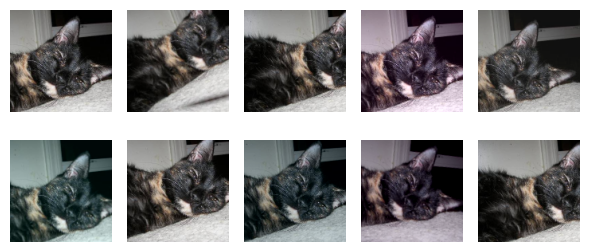

In [16]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 3))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
visualize_augmentations(train_dataset)

In [17]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [18]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [19]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1, plain=False):

        super().__init__()
        if not subsample:
            c_out = c_in

        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )

        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None
        
        self.plain = plain

    def forward(self, x):
        if self.plain:
            x = self.net(x)
            return x
        else:
            z = self.net(x)
            if self.downsample is not None:
                x = self.downsample(x)
            out = z + x
            return out

In [20]:
from types import SimpleNamespace

act_fn_by_name = {
    "tanh" : nn.Tanh,
    "relu" : nn.ReLU,
    "leakyrelu" : nn.LeakyReLU,
    "gelu" : nn.GELU
}

class ResNet(nn.Module):

    def __init__(self,
                 num_classes=1,
                 num_blocks=[3, 4, 6, 3],
                 c_hidden=[64, 128, 256, 512],
                 act_fn_name="relu",
                 plain=False,
                 **kwargs):

        super().__init__()
        
        self.hparams = SimpleNamespace(
            num_classes=num_classes,
            c_hidden=c_hidden,
            num_blocks=num_blocks,
            act_fn_name=act_fn_name,
            act_fn=act_fn_by_name[act_fn_name],
            plain=plain,
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # A first convolution on the original image to scale up the channel size

        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False))

        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (
                    bc == 0 and block_idx > 0
                )  # Subsample the first block of each group, except the very first one.
                blocks.append(
                    PreActResNetBlock(
                        c_in=c_hidden[block_idx if not subsample else
                                      (block_idx - 1)],
                        act_fn=self.hparams.act_fn,
                        subsample=subsample,
                        c_out=c_hidden[block_idx],
                        plain=self.hparams.plain,
                    ))
        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes))

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [21]:
from torchsummary import summary
res_model = ResNet() # pre_activation 모델입니다.
summary(res_model, (3,128,128), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          36,864
 PreActResNetBlock-8         [-1, 64, 128, 128]               0
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
           Conv2d-14         [-1, 64, 1

In [22]:
res_model = res_model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(res_model.parameters(), lr=params["lr"])
accuracy = BinaryAccuracy().to(params["device"])

In [33]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [24]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        acc = accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", acc.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [25]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            acc = accuracy(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", acc.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [26]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, res_model, criterion, optimizer, epoch, params)
    validate(val_loader, res_model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.745 | Accuracy: 0.536: 100%|██████████| 1250/1250 [06:28<00:00,  3.22it/s]
Epoch: 1. Validation. Accuracy: 0.516 | Loss: 0.724: 100%|██████████| 307/307 [00:49<00:00,  6.24it/s]
Epoch: 2. Train.      Loss: 0.677 | Accuracy: 0.579: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s]
Epoch: 2. Validation. Accuracy: 0.654 | Loss: 0.650: 100%|██████████| 307/307 [00:45<00:00,  6.82it/s]
Epoch: 3. Train.      Loss: 0.650 | Accuracy: 0.629: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s]
Epoch: 3. Validation. Accuracy: 0.674 | Loss: 0.619: 100%|██████████| 307/307 [00:45<00:00,  6.74it/s]
Epoch: 4. Train.      Loss: 0.617 | Accuracy: 0.665: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s]
Epoch: 4. Validation. Accuracy: 0.700 | Loss: 0.587: 100%|██████████| 307/307 [00:45<00:00,  6.81it/s]
Epoch: 5. Train.      Loss: 0.587 | Accuracy: 0.696: 100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s]
Epoch: 5. Validation. Accuracy: 0.615 | Loss: 0.691: 100%|█████

In [28]:
validate(test_loader, res_model, criterion, epoch, params)

Epoch: 10. Validation. Accuracy: 0.911 | Loss: 0.301: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]


In [30]:
plain_res_model = ResNet(plain=True) # pre_activation 모델입니다.
summary(plain_res_model, (3,128,128), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          36,864
 PreActResNetBlock-8         [-1, 64, 128, 128]               0
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
           Conv2d-14         [-1, 64, 1

In [31]:
plain_res_model = plain_res_model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(plain_res_model.parameters(), lr=params["lr"])
accuracy = BinaryAccuracy().to(params["device"])

In [32]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, plain_res_model, criterion, optimizer, epoch, params)
    validate(val_loader, plain_res_model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.690 | Accuracy: 0.578: 100%|██████████| 1250/1250 [06:01<00:00,  3.46it/s]
Epoch: 1. Validation. Accuracy: 0.648 | Loss: 0.649: 100%|██████████| 307/307 [00:42<00:00,  7.16it/s]
Epoch: 2. Train.      Loss: 0.626 | Accuracy: 0.653: 100%|██████████| 1250/1250 [06:04<00:00,  3.43it/s]
Epoch: 2. Validation. Accuracy: 0.696 | Loss: 0.590: 100%|██████████| 307/307 [00:43<00:00,  7.02it/s]
Epoch: 3. Train.      Loss: 0.622 | Accuracy: 0.663: 100%|██████████| 1250/1250 [06:04<00:00,  3.43it/s]
Epoch: 3. Validation. Accuracy: 0.695 | Loss: 0.587: 100%|██████████| 307/307 [00:42<00:00,  7.19it/s]
Epoch: 4. Train.      Loss: 0.614 | Accuracy: 0.668: 100%|██████████| 1250/1250 [06:03<00:00,  3.44it/s]
Epoch: 4. Validation. Accuracy: 0.664 | Loss: 0.628: 100%|██████████| 307/307 [00:43<00:00,  7.07it/s]
Epoch: 5. Train.      Loss: 0.605 | Accuracy: 0.680: 100%|██████████| 1250/1250 [06:03<00:00,  3.44it/s]
Epoch: 5. Validation. Accuracy: 0.694 | Loss: 0.606: 100%|█████

In [34]:
validate(test_loader, plain_res_model, criterion, epoch, params)

Epoch: 10. Validation. Accuracy: 0.777 | Loss: 0.551: 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


10 epochs 결과
* Resnet : 0.911
* Plain_Resnet : 0.777